10:48:34 - cmdstanpy - INFO - Chain [1] start processing
10:48:34 - cmdstanpy - INFO - Chain [1] done processing



Dataset Information:
Training data ranges from 2021-06-28 00:00:00 to 2024-04-26 00:00:00
Total records: 710

Model Performance Metrics:
Test MAE: 254.26
Test RMSE: 293.65
Test R2: -2.70


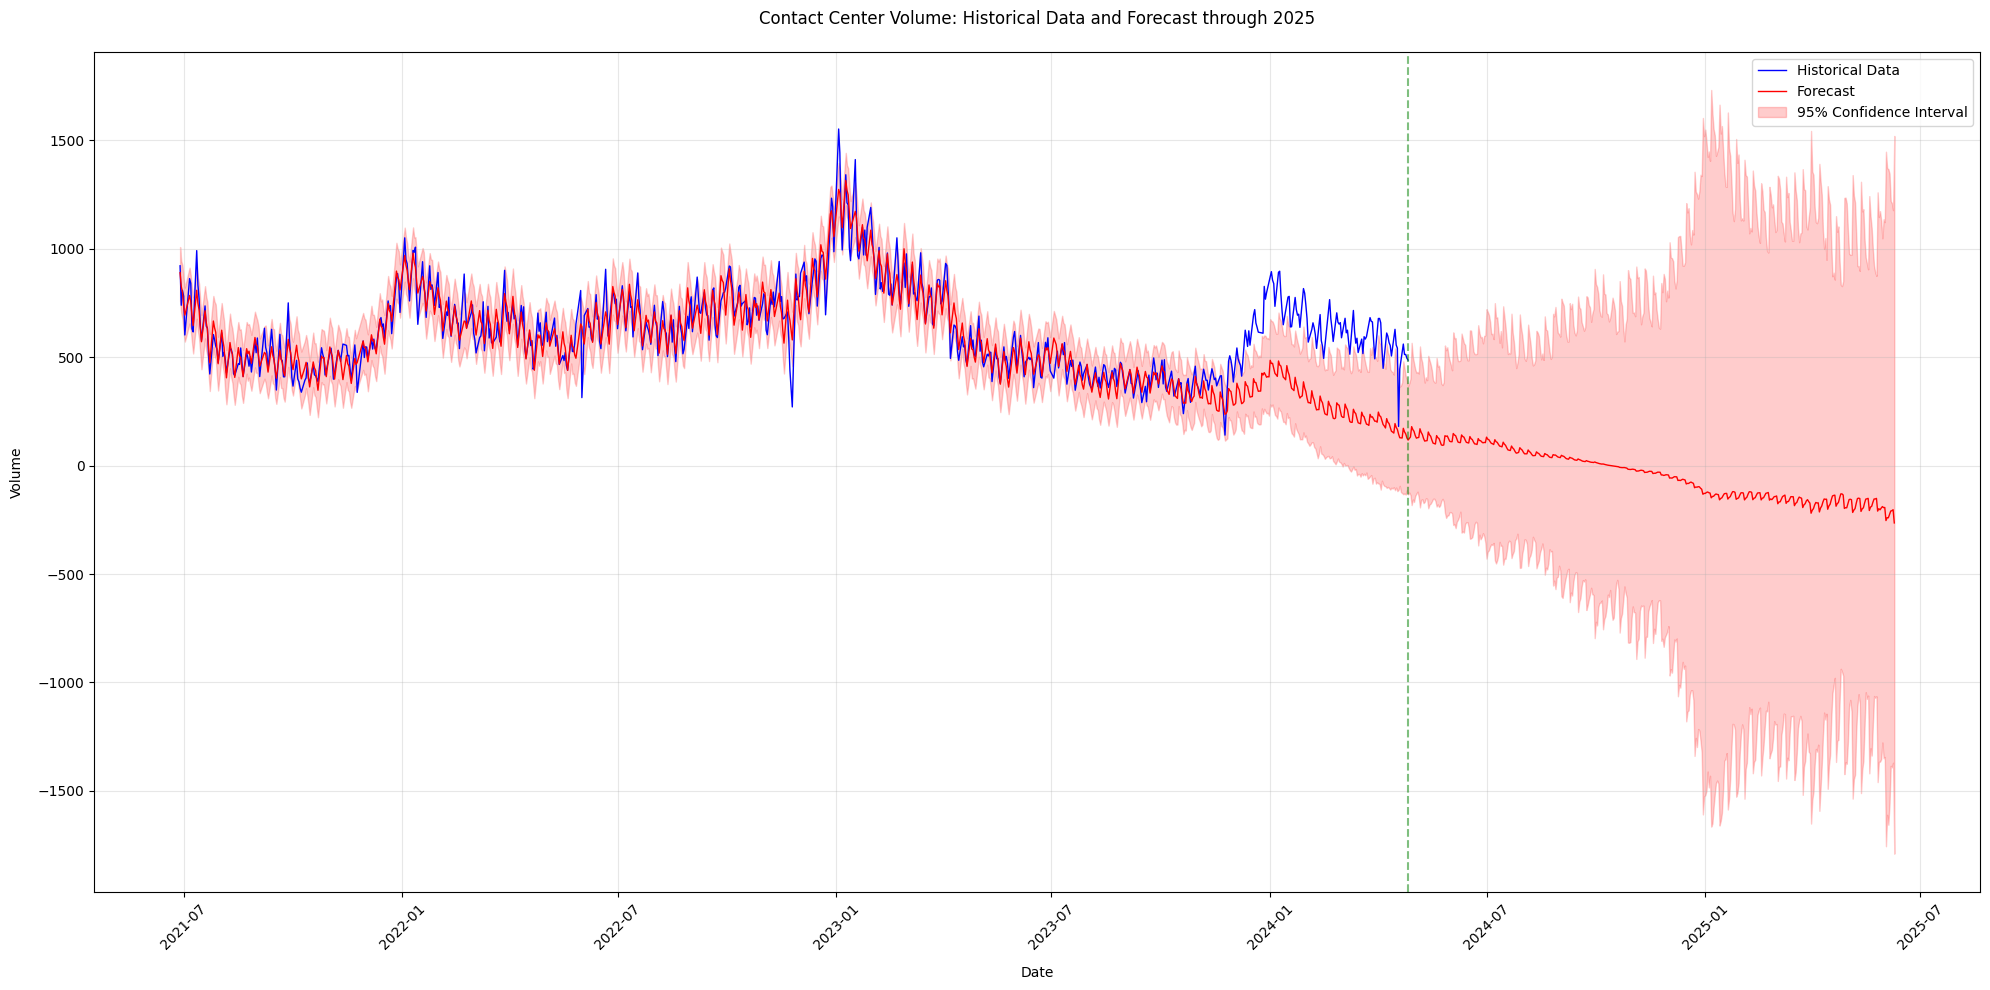

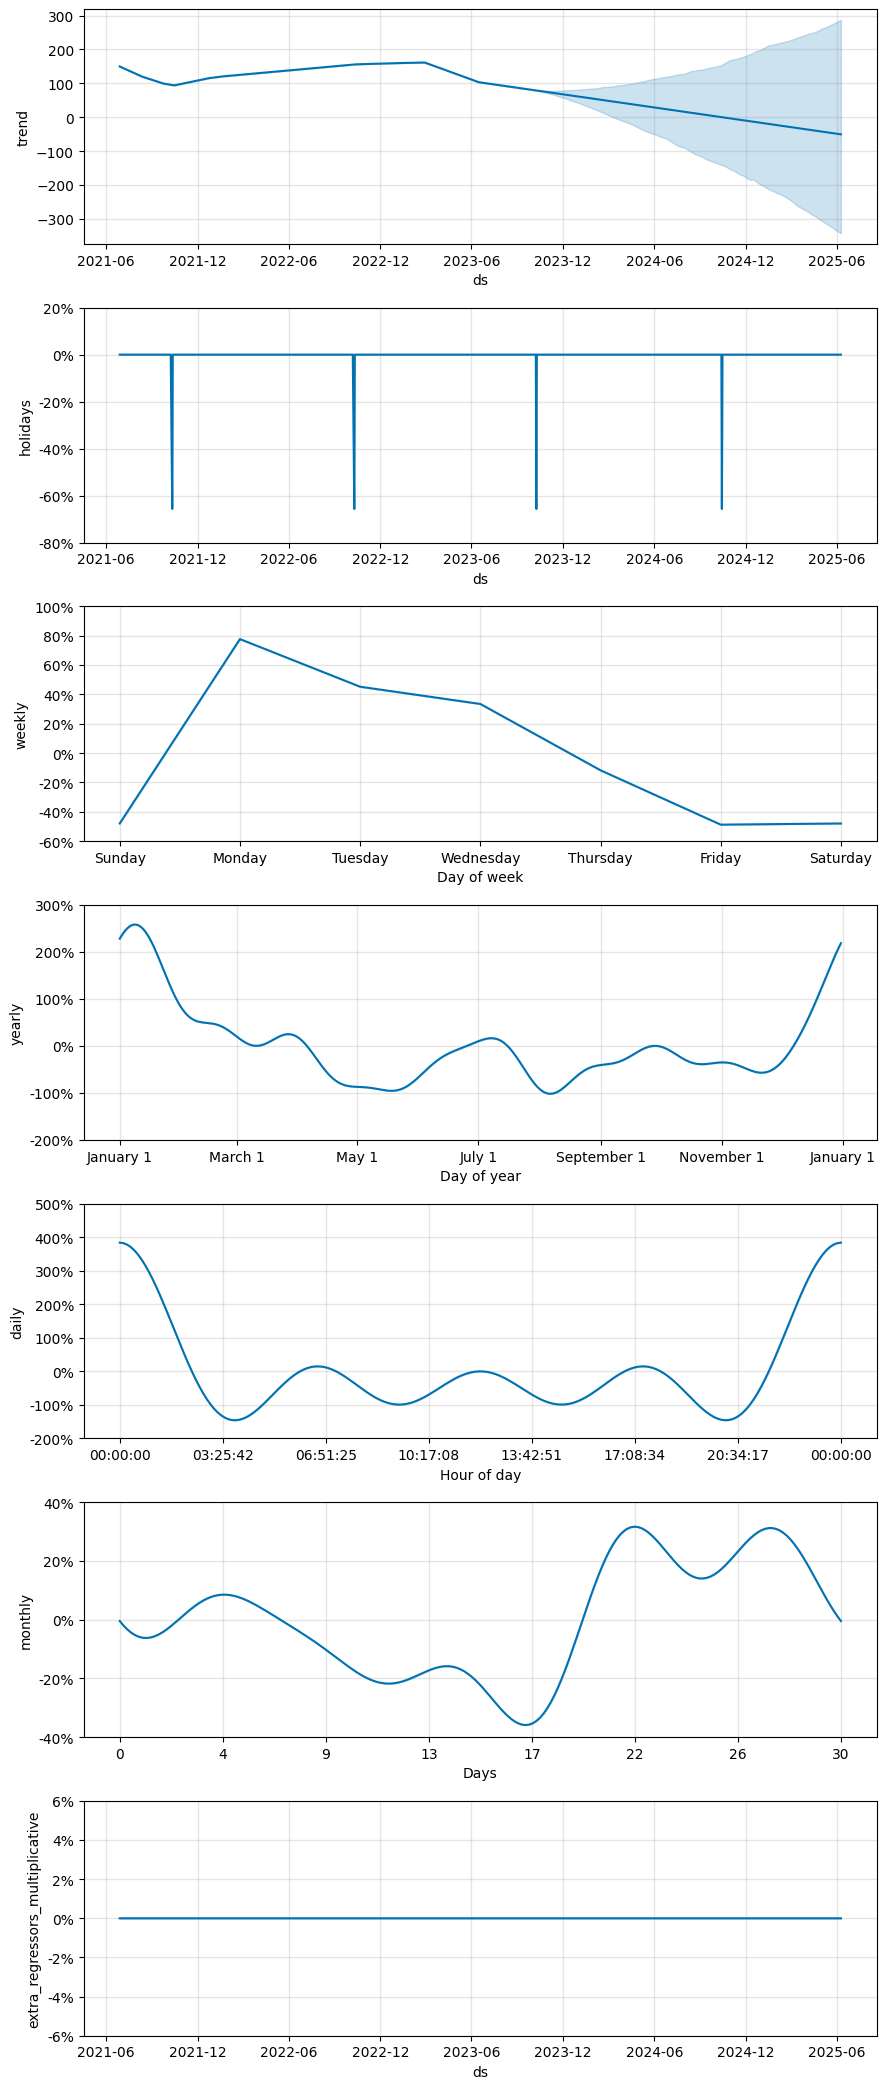


Forecast Summary:

Next 30 days forecast:
        ds       yhat  yhat_lower  yhat_upper
2024-04-27 125.424634 -123.933750  380.156345
2024-04-28 132.349436 -135.265248  401.229961
2024-04-29 180.198950 -181.969485  566.676593
2024-04-30 166.679951 -155.821538  502.236881
2024-05-01 158.250002 -167.341048  473.496656
2024-05-02 139.505248 -139.769227  445.199282
2024-05-03 126.946142 -128.785742  428.948292
2024-05-04 129.382924 -120.012188  432.512714
2024-05-05 130.141675 -145.692823  425.218376
2024-05-06 170.332188 -192.591855  550.021239
2024-05-07 153.577943 -157.854129  496.522275
2024-05-08 143.997843 -154.933407  474.249748
2024-05-09 125.797819 -172.753696  428.031231
2024-05-10 113.402571 -166.857756  383.172354
2024-05-11 114.924953 -150.288556  407.734418
2024-05-12 115.417057 -152.732826  394.400155
2024-05-13 155.350571 -196.516939  506.769038
2024-05-14 142.320850 -179.337642  486.802931
2024-05-15 135.815612 -175.150915  467.605455
2024-05-16 118.650647 -165.116699  44

In [ ]:
#**Please note this file uses false filepaths/keys for public consumption, Therefore attmepting to re-run this code will return an error.

import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def load_data(file_path):
    """Load and prepare data in Prophet format."""
    df = pd.read_csv('contact_volume.csv')
    df['ds'] = pd.to_datetime(df['ds'], format='%m/%d/%y')
    
    # Handle missing values
    if 'y' not in df.columns and 'volume' in df.columns:
        df['y'] = df['volume']
    
    # Remove rows with NaN values
    df = df.dropna(subset=['ds', 'y'])
    
    # Ensure y values are numeric and positive
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df = df.dropna(subset=['y'])
    df['y'] = df['y'].clip(lower=0)  # Ensure no negative values
    
    return df[['ds', 'y']]

def create_prophet_model():
    """Create and configure Prophet model with optimized parameters."""
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,  # Added daily seasonality
        seasonality_mode='multiplicative',
        interval_width=0.95,
        seasonality_prior_scale=20,  # Increased for stronger seasonality
        holidays_prior_scale=15,     # Increased holiday effects
        changepoint_prior_scale=0.08,  # More flexible trend changes
        changepoint_range=0.95,        # Allow changepoints until 95% of the data
        n_changepoints=35              # Increased number of changepoints
    )
    
    # Add country holidays with increased importance
    model.add_country_holidays(country_name='US')
    
    # Add weekend effect
    model.add_regressor('weekend', prior_scale=15)
    
    # Add additional seasonality for monthly patterns
    model.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=5
    )
    
    return model

def train_and_evaluate(df):
    """Train Prophet model and evaluate performance."""
    print("\nDataset Information:")
    print(f"Training data ranges from {df['ds'].min()} to {df['ds'].max()}")
    print(f"Total records: {len(df)}")
    
    # Validate input data
    if df.empty:
        raise ValueError("DataFrame is empty after cleaning")
    
    # Use 80% for training, 20% for testing
    train_size = int(len(df) * 0.8)
    train_df = df[:train_size].copy()
    test_df = df[train_size:].copy()
    
    # Add weekend feature
    train_df['weekend'] = 0
    train_df.loc[train_df['ds'].dt.dayofweek.isin([5, 6]), 'weekend'] = 1
    
    # Create and fit model
    model = create_prophet_model()
    model.fit(train_df)
    
    # Prepare test data
    future_dates_test = pd.DataFrame({'ds': test_df['ds']})
    future_dates_test['weekend'] = 0
    future_dates_test.loc[future_dates_test['ds'].dt.dayofweek.isin([5, 6]), 'weekend'] = 1
    
    # Make predictions
    forecast_test = model.predict(future_dates_test)
    test_predictions = forecast_test['yhat']
    
    # Ensure test data and predictions are aligned
    valid_mask = ~(test_df['y'].isna() | test_predictions.isna())
    
    if not valid_mask.any():
        print("Warning: No valid data points for evaluation")
        return model, forecast_test
    
    # Calculate metrics
    mae = mean_absolute_error(test_df['y'][valid_mask], test_predictions[valid_mask])
    rmse = np.sqrt(mean_squared_error(test_df['y'][valid_mask], test_predictions[valid_mask]))
    r2 = r2_score(test_df['y'][valid_mask], test_predictions[valid_mask])
    
    print("\nModel Performance Metrics:")
    print(f"Test MAE: {mae:.2f}")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test R2: {r2:.2f}")
    
    return model, forecast_test

def make_future_predictions(model, df, target_end_date=None):
    """Generate and plot future predictions through a specified end date."""
    if target_end_date is None:
        target_end_date = datetime(2025, 12, 31)
    
    # Calculate number of days to forecast
    last_date = df['ds'].max()
    days_to_forecast = (target_end_date - last_date.to_pydatetime()).days
    
    # Create future dataframe
    future_df = model.make_future_dataframe(periods=days_to_forecast)
    
    # Add weekend feature
    future_df['weekend'] = 0
    future_df.loc[future_df['ds'].dt.dayofweek.isin([5, 6]), 'weekend'] = 1
    
    # Make predictions
    forecast = model.predict(future_df)
    
    # Plotting with enhanced visualization
    plt.figure(figsize=(20, 10))
    
    # Plot historical data
    plt.plot(df['ds'], df['y'], label='Historical Data', color='blue', linewidth=1)
    
    # Plot forecast
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linewidth=1)
    
    # Plot confidence interval
    plt.fill_between(forecast['ds'], 
                    forecast['yhat_lower'], 
                    forecast['yhat_upper'],
                    color='red', 
                    alpha=0.2, 
                    label='95% Confidence Interval')
    
    # Enhance plot appearance
    plt.title('Contact Center Volume: Historical Data and Forecast through 2025', pad=20)
    plt.xlabel('Date', labelpad=10)
    plt.ylabel('Volume', labelpad=10)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add vertical line for current date
    current_date = df['ds'].max()
    plt.axvline(x=current_date, color='green', linestyle='--', alpha=0.5, label='Current Date')
    
    plt.tight_layout()
    plt.show()
    
    # Plot components
    model.plot_components(forecast)
    plt.show()
    
    return forecast

if __name__ == "__main__":
    try:
        # Load and validate data
        df = load_data('/contact_volume.csv')
        
        # Train model and generate forecasts
        model, forecast_test = train_and_evaluate(df)
        
        # Make future predictions through 2025
        target_end_date = datetime(2025, 12, 31)
        forecast = make_future_predictions(model, df, target_end_date)
        
        print("\nForecast Summary:")
        print("\nNext 30 days forecast:")
        next_30_days = forecast[forecast['ds'] > df['ds'].max()].head(30)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        print(next_30_days.to_string(index=False))
        
        print("\nMonthly averages for 2025:")
        forecast_2025 = forecast[forecast['ds'].dt.year == 2025]
        monthly_avg = forecast_2025.groupby(forecast_2025['ds'].dt.strftime('%Y-%m'))[['yhat', 'yhat_lower', 'yhat_upper']].mean()
        print(monthly_avg.round(2).to_string())
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")